# Music Genre Classification using Neural Network

In [106]:
import pandas as pd
import numpy as np
import platform
import matplotlib.pyplot as plt
import utils
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Accuracy, AUC, F1Score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [107]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        if tf.test.is_built_with_cuda():
            print(f"CUDA is enabled. Using GPU(s) with CUDA: {physical_devices}")
        elif platform.system() == 'Darwin':
            print(f"Metal is enabled. Using Metal-enabled GPU on macOS: {physical_devices}")
        else:
            print(f"GPU detected but neither CUDA nor Metal is enabled: {physical_devices}")
    except RuntimeError as e:
        print(f"Error enabling GPU acceleration: {e}")
else:
    print("No GPU found. Running on CPU.")

No GPU found. Running on CPU.


In [108]:
# Load MFCC data
mfcc_df = utils.load_mfcc_data()
labels = pd.read_csv('project_data/tracks.csv')['genre']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Drop non-numeric columns
mfcc_df = mfcc_df.drop(columns=['file_name'])

# Flatten multi-index columns and scale features
mfcc_df.columns = ['_'.join(map(str, col)) for col in mfcc_df.columns]
scaler = StandardScaler()
X = scaler.fit_transform(mfcc_df)

C:\Users\komputer\AppData\Local\Temp\ipykernel_16848\1356630702.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mfcc_df = mfcc_df.drop(columns=['file_name'])


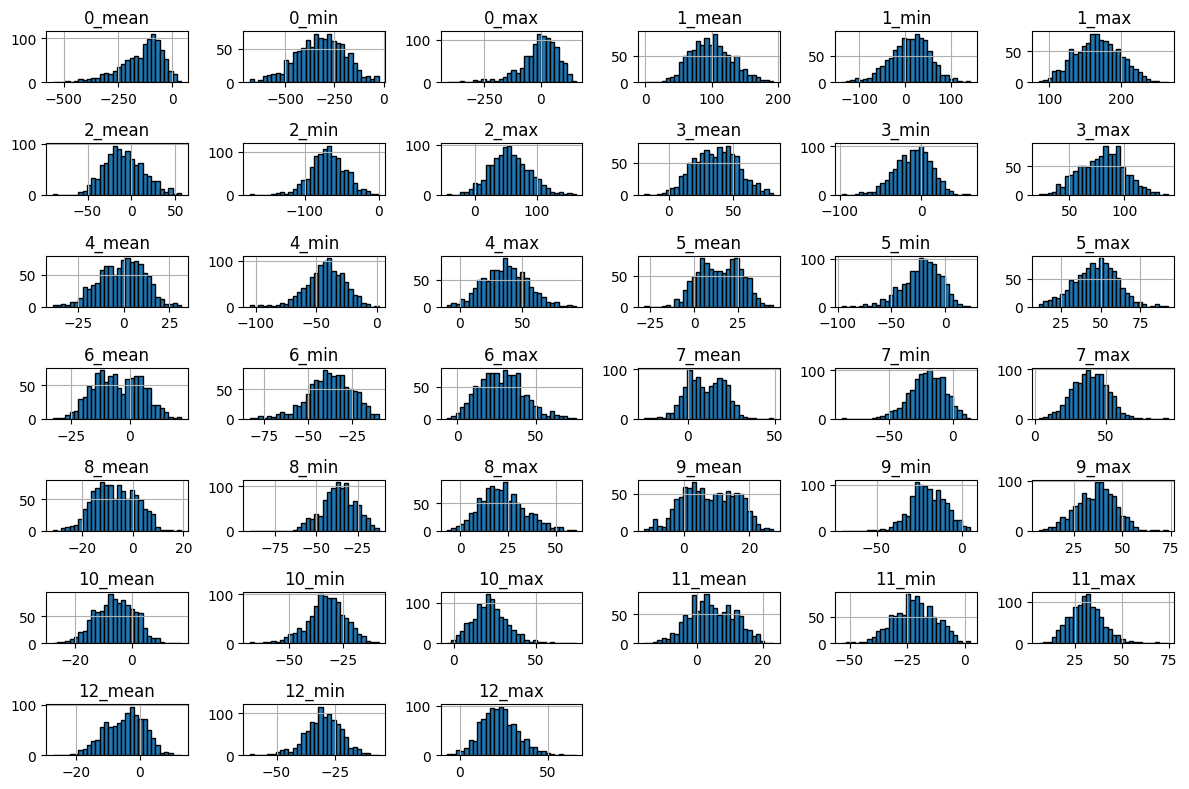

In [109]:
mfcc_df.hist(bins=30, figsize=(12, 8), edgecolor='black')
plt.tight_layout()
plt.show()

In [110]:
y = to_categorical(y, num_classes=10)

In [111]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y.argmax(axis=1),
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    stratify=y_train_full.argmax(axis=1),
    random_state=42
)

In [112]:
print(np.isnan(X_train).sum())  # Liczba NaN w X_train
print(np.isnan(y_train).sum())  # Liczba NaN w y_train

0
0


In [135]:
def build_and_train_model(X_train, y_train, X_val, y_val,
                          hidden_layers=[64, 32],
                          output_activation='softmax',
                          loss='categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy', Precision(name='precision')],
                          monitor_metric='val_precision',
                          model_path='best_model.h5',
                          epochs=20,
                          batch_size=32,
                          patience=5,
                          dropout=0.2):

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(hidden_layers[0]))
    model.add(LeakyReLU(negative_slope=0.1))
    for units in hidden_layers[1:]:
        model.add(Dense(units))
        model.add(LeakyReLU(negative_slope=0.1))
        model.add(BatchNormalization())
        model.add(Dropout(dropout)),
    model.add(Dense(10, activation=output_activation))

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    checkpoint = ModelCheckpoint(
        model_path,
        monitor=monitor_metric,
        mode='min',
        save_best_only=True,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor=monitor_metric,
        patience=patience,
        mode='min',
        verbose=1,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, early_stopping]
    )

    return model, history


In [136]:
model, history = build_and_train_model(
    X_train, y_train,
    X_val, y_val,
    hidden_layers=[254, 128, 64],
    optimizer=Adam(learning_rate=0.0001),
    metrics=[AUC(), F1Score(), 'accuracy', Precision(name='precision')],
    monitor_metric='val_loss',
    model_path='najlepszy_model.keras',
    epochs=500,
    batch_size=64,
    patience=100,
    dropout=0.45
)

Epoch 1/500
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1407 - auc_5: 0.5419 - f1_score: 0.1376 - loss: 3.1008 - precision: 0.1148
Epoch 1: val_loss improved from inf to 2.26401, saving model to najlepszy_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.1379 - auc_5: 0.5423 - f1_score: 0.1351 - loss: 3.1050 - precision: 0.1193 - val_accuracy: 0.1125 - val_auc_5: 0.5786 - val_f1_score: 0.0777 - val_loss: 2.2640 - val_precision: 0.0000e+00
Epoch 2/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0781 - auc_5: 0.5354 - f1_score: 0.0756 - loss: 3.1707 - precision: 0.1364
Epoch 2: val_loss improved from 2.26401 to 2.21876, saving model to najlepszy_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1132 - auc_5: 0.5427 - f1_score: 0.1125 - loss: 3.1198 - precision: 0.1278 - val_accuracy: 0.1312 - val_auc_5: 0.6413 - val_f1_score: 0.1107 - val_loss: 2.2188 - val_precision: 0.0000e+00
Epoch 3/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accur

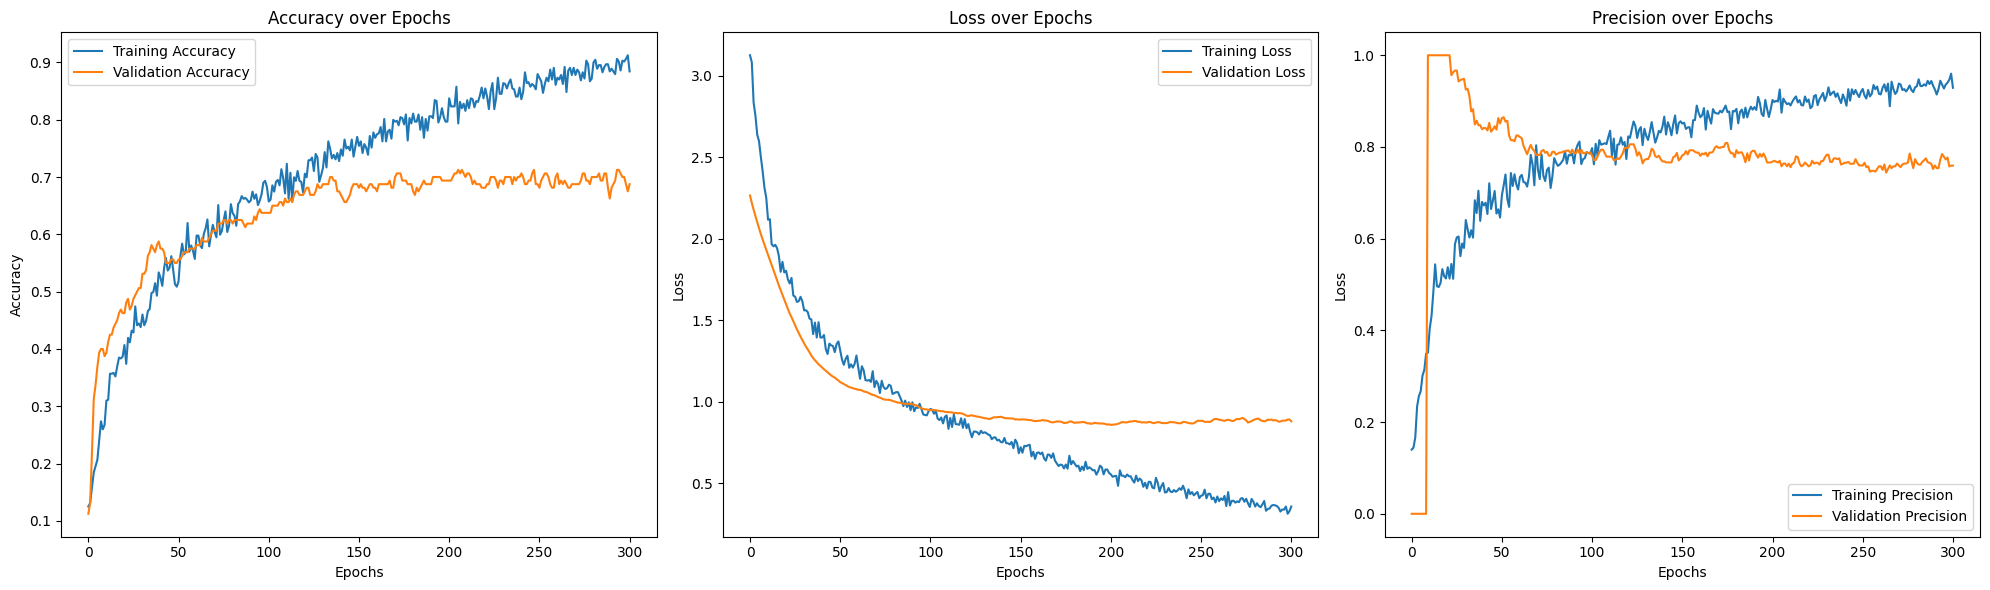

In [137]:
plt.figure(figsize=(20, 6))

# Plot training and validation accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [138]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print("Dokładność:", accuracy)
print("Precyzja (macro):", precision)
print("F1 score (macro):", f1)
print("Macierz pomyłek:\n", conf_matrix)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Dokładność: 0.625
Precyzja (macro): 0.6288971585635753
F1 score (macro): 0.6140572220430827
Macierz pomyłek:
 [[ 7  0  1  2  0  0  1  0  5  4]
 [ 0 19  0  0  0  1  0  0  0  0]
 [ 3  0 12  0  0  1  1  0  1  2]
 [ 1  1  0  5  2  0  1  5  1  4]
 [ 0  0  0  1 10  0  1  1  4  3]
 [ 0  1  0  0  0 18  0  0  0  1]
 [ 1  0  0  0  1  0 14  0  0  4]
 [ 0  0  0  0  0  0  0 19  1  0]
 [ 0  0  2  0  2  0  0  3 12  1]
 [ 2  0  3  1  1  3  0  1  0  9]]


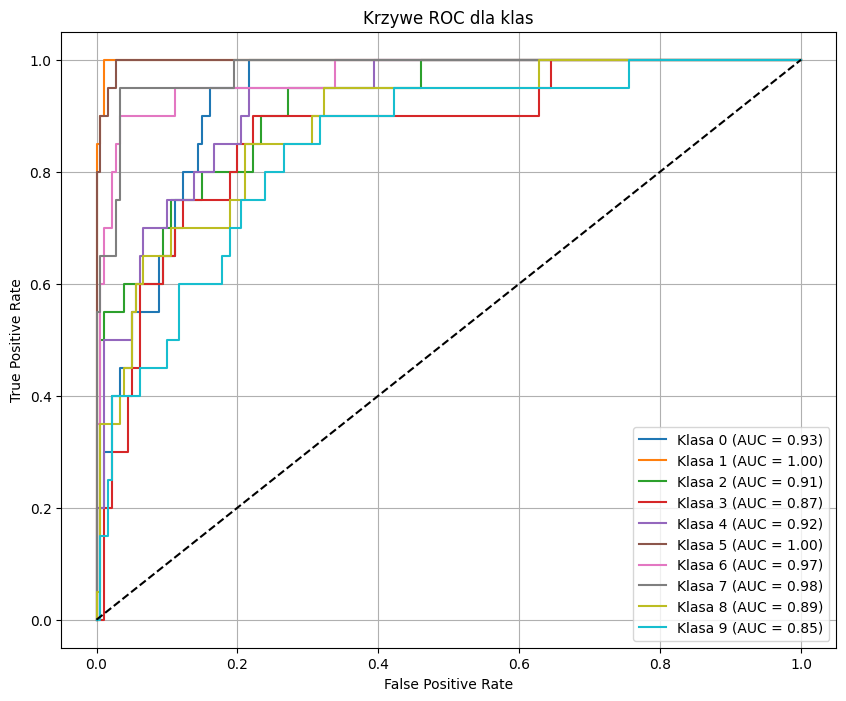

In [139]:
y_true_bin = label_binarize(y_true, classes=range(10))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Klasa {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywe ROC dla klas')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
